<a href="https://colab.research.google.com/github/yajima-yasutoshi/Model/blob/main/20250723/%E6%9C%80%E5%B0%8F%E8%B2%BB%E7%94%A8%E6%B5%81%E5%95%8F%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#準備

In [ ]:
%%capture
!pip install mip
!pip install japanize-matplotlib

# 最小費用流問題
本講義では、
**最小費用流問題 (Minimum Cost Flow Problem)** について学びます。
最小費用流問題は、与えられたネットワークにおいて、
指定された複数の供給ノードから複数の需要ノードへの「フロー」（物資、データ、電力などの輸送）を考えます。各経路に設定された容量（フローの上限）制約のもとで、
枝に設定された費用の合計（総輸送費用）を最小化するような
フローの輸送計画を決定する問題です。

**ネットワークの構成要素:**
ノードとアークから構成されるネットワークを考える。
* **ノード (Nodes):** ノードは以下の種類に分類されます。
    * **供給ノード (Source/Supply Node):** フローを供給するノード（図のF1,F2）。供給量の上限が定められます（正の値で表現）。
    * **需要ノード (Sink/Demand Node):** フローを消費するノード（図のC1,C2,C3）。需要量の下限が定められます。便宜的に負の供給値として表現する。
    * **中継ノード (Transshipment Node):** フローが通過するだけで、供給も需要も0であるノード（図のW1,W2）。
* **アーク (Arcs):** 2つのノード間を結ぶ有向の経路を表し、フローは矢印で示す特定の方向に流れるとします。各アークには以下の属性が付随します。
    * **費用 (Cost, $c_{ij}$):** アーク $(i,j)$ 上を単位量のフローを流すのにかかる費用。
    * **容量 (Capacity, $u_{ij}$):** アーク $(i,j)$ 上を流れることができるフローの最大量。下限容量 ($l_{ij}$) が設定されることもある。
* **ノードバランス (Node Balance, $b_k$):** 各ノード $k$ におけるフローの供給量を $b_k$ とする（需要量の場合は負の供給量と考える）。すなわち、
  * 供給ノードでは $b_k > 0$
  * 需要ノードでは $b_k < 0$
  * 中継ノードでは $b_k = 0$
  
  とする。多くの場合、ネットワーク全体で総供給量と総需要量がバランスしている、
  すなわち
$$
\sum_k b_k = 0
$$
となる、**均衡**状態の問題を考える。

**最適化の目的:**
 全てのノードでのフローの需要と供給のバランスを満たし（フロー保存則）、
 かつ全てのアークの容量制約を守りながら、
 総輸送費用を最小にする輸送方法を求めることである。


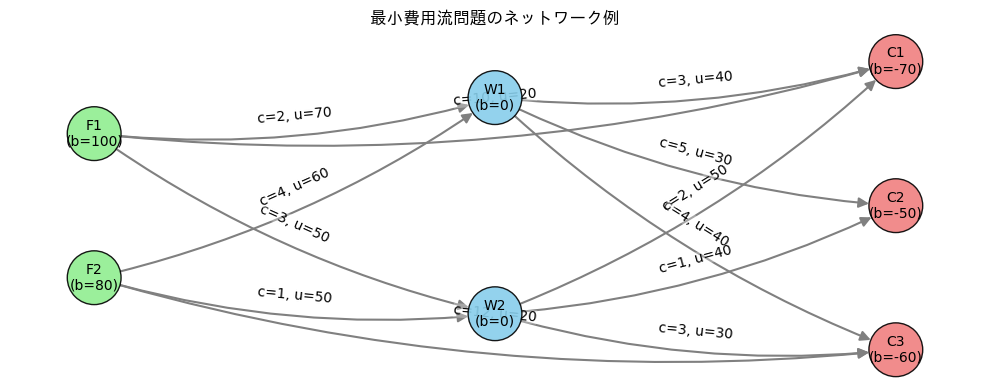

In [ ]:
#@title ネットワークの図示

import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib #日本語フォント対応
import numpy as np
import pandas as pd

# ネットワークデータ
nodes_data_mcf = {
    'F1': {'balance': 100, 'type': 'supply', 'pos': (0, 2)},
    'F2': {'balance': 80,  'type': 'supply', 'pos': (0, 0)},
    'W1': {'balance': 0,   'type': 'transshipment', 'pos': (2, 2.5)},
    'W2': {'balance': 0,   'type': 'transshipment', 'pos': (2, -0.5)},
    'C1': {'balance': -70, 'type': 'demand', 'pos': (4, 3)},
    'C2': {'balance': -50, 'type': 'demand', 'pos': (4, 1)},
    'C3': {'balance': -60, 'type': 'demand', 'pos': (4, -1)}
}
arcs_data_mcf = [
    ('F1', 'W1', 2, 70), ('F1', 'W2', 3, 50),
    ('F2', 'W1', 4, 60), ('F2', 'W2', 1, 50),
    ('W1', 'C1', 3, 40), ('W1', 'C2', 5, 30), ('W1', 'C3', 4, 40),
    ('W2', 'C1', 2, 50), ('W2', 'C2', 1, 40), ('W2', 'C3', 3, 30),
    ('F1', 'C1', 10, 20),('F2', 'C3', 12, 20) # (始点, 終点, 費用, 容量)
]

# グラフオブジェクトの作成
G_mcf_problem = nx.DiGraph()
node_names_mcf = list(nodes_data_mcf.keys())
G_mcf_problem.add_nodes_from(node_names_mcf)

for u, v, cost, capacity in arcs_data_mcf:
    G_mcf_problem.add_edge(u, v, cost=cost, capacity=capacity)

# ノードの描画位置
pos_mcf = {name: data['pos'] for name, data in nodes_data_mcf.items()}

# ノードの色分け
color_map_mcf = []
for node in G_mcf_problem.nodes():
    if nodes_data_mcf[node]['type'] == 'supply': color_map_mcf.append('lightgreen')
    elif nodes_data_mcf[node]['type'] == 'demand': color_map_mcf.append('lightcoral')
    else: color_map_mcf.append('skyblue')

# 描画
plt.figure(figsize=(10, 4))
node_draw_size_mcf = 1500

nx.draw_networkx_nodes(G_mcf_problem, pos_mcf, node_size=node_draw_size_mcf, node_color=color_map_mcf, alpha=0.9, edgecolors="black")
node_labels_mcf = {name: f"{name}\n(b={data['balance']})" for name, data in nodes_data_mcf.items()}
nx.draw_networkx_labels(G_mcf_problem, pos_mcf, labels=node_labels_mcf, font_size=10)#, font_weight='bold')

nx.draw_networkx_edges(G_mcf_problem, pos_mcf, width=1.5, arrowstyle='-|> ', arrowsize=15, edge_color='gray',
                       connectionstyle='arc3,rad=0.1', node_size=node_draw_size_mcf, min_source_margin=18, min_target_margin=18)

edge_labels_mcf = {(u,v): f"c={d['cost']}, u={d['capacity']}" for u,v,d in G_mcf_problem.edges(data=True)}
nx.draw_networkx_edge_labels(G_mcf_problem, pos_mcf, edge_labels=edge_labels_mcf, font_size=10, font_color='black',
                             bbox=dict(facecolor='white', alpha=0.3, edgecolor='none', pad=0.1))

plt.title("最小費用流問題のネットワーク例", fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.show()


**実社会での応用例:**
* **物流・サプライチェーン最適化:** 製品を複数の工場（供給ノード）から倉庫（中継ノード）を経由して、複数の顧客（需要ノード）へ最小の総輸送コストで配送する計画。
* **通信ネットワーク:** データパケットをネットワーク上で、回線費用と帯域容量を考慮して、最小コストでルーティングする。
* **エネルギー供給網:** 発電所から変電所ネットワークを経由して消費者へ電力を最小コストで供給する。
* **生産計画:** 原材料の調達、中間製品の生産、完成品の市場への供給といった一連のプロセスを、各工程のコストと生産能力を考慮して最適化する。
* **割り当て問題の一般化:** 最小費用流問題は、最短経路問題、最大流問題、輸送問題、割り当て問題などを特殊なケースとして含む、より一般的な枠組みです。

この問題は線形計画問題として定式化できる。


---
## 定式化の詳細

具体的なネットワーク例を用いて最小費用流問題の定式化を行います。

###例題

ある企業が2つの工場（F1, F2）で製品を生産し、2つの中間倉庫（W1, W2）を経由して、3つの主要な顧客（C1, C2, C3）へ製品を供給する計画を立てています。各工場には生産上限（供給量）、各顧客には需要量があります。
工場から倉庫へ、倉庫から顧客へ、そして一部の工場から顧客への直接輸送ルートも存在し、それぞれ輸送コストと輸送容量が設定されています。

* **ノードとバランス ($b_k$):**
    * F1 (工場1): 供給量が100 ユニット
    * F2 (工場2): 供給量が80 ユニット
    * W1 (倉庫1): 中継点
    * W2 (倉庫2): 中継点
    * C1 (顧客1): 需要量が70 ユニット (つまり-70ユニットの供給量)
    * C2 (顧客2): 需要量が50 ユニット (つまり-50ユニットの供給量)
    * C3 (顧客3): 需要量が60 ユニット (つまり-60ユニットの供給量)
  
  総供給量 = $100+80=180$、総需要量 = $70+50+60=180$ となり、問題は均衡している。

* **アーク (始点, 終点, 単位費用, 容量):** 以下の示すようなアークを考える。
    * (F1, W1, 2, 70), (F1, W2, 3, 50)
    * (F2, W1, 4, 60), (F2, W2, 1, 50)
    * (W1, C1, 3, 40), (W1, C2, 5, 30), (W1, C3, 4, 40)
    * (W2, C1, 2, 50), (W2, C2, 1, 40), (W2, C3, 3, 30)
    * (F1, C1, 10, 20)  // F1からC1への直接輸送
    * (F2, C3, 12, 20)  // F2からC3への直接輸送

このネットワークを図示すると以下のようになる。



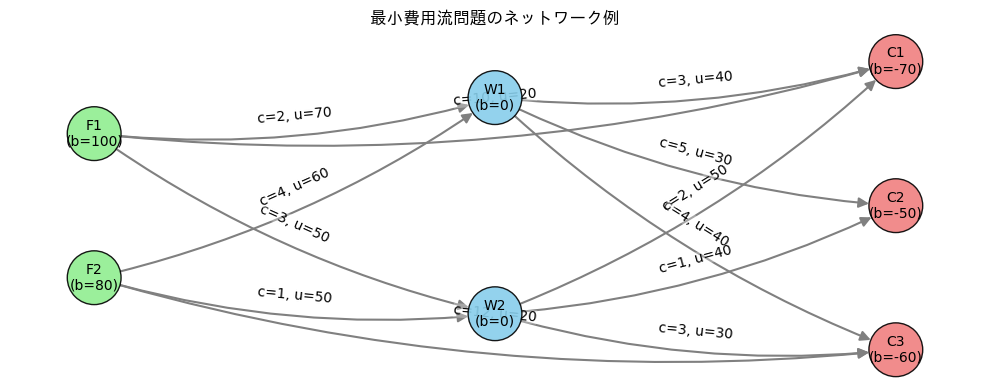

In [ ]:
#@title ネットワークの図示

import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib #日本語フォント対応
import numpy as np
import pandas as pd

# ネットワークデータ
nodes_data_mcf = {
    'F1': {'balance': 100, 'type': 'supply', 'pos': (0, 2)},
    'F2': {'balance': 80,  'type': 'supply', 'pos': (0, 0)},
    'W1': {'balance': 0,   'type': 'transshipment', 'pos': (2, 2.5)},
    'W2': {'balance': 0,   'type': 'transshipment', 'pos': (2, -0.5)},
    'C1': {'balance': -70, 'type': 'demand', 'pos': (4, 3)},
    'C2': {'balance': -50, 'type': 'demand', 'pos': (4, 1)},
    'C3': {'balance': -60, 'type': 'demand', 'pos': (4, -1)}
}
arcs_data_mcf = [
    ('F1', 'W1', 2, 70), ('F1', 'W2', 3, 50),
    ('F2', 'W1', 4, 60), ('F2', 'W2', 1, 50),
    ('W1', 'C1', 3, 40), ('W1', 'C2', 5, 30), ('W1', 'C3', 4, 40),
    ('W2', 'C1', 2, 50), ('W2', 'C2', 1, 40), ('W2', 'C3', 3, 30),
    ('F1', 'C1', 10, 20),('F2', 'C3', 12, 20) # (始点, 終点, 費用, 容量)
]

# グラフオブジェクトの作成
G_mcf_problem = nx.DiGraph()
node_names_mcf = list(nodes_data_mcf.keys())
G_mcf_problem.add_nodes_from(node_names_mcf)

for u, v, cost, capacity in arcs_data_mcf:
    G_mcf_problem.add_edge(u, v, cost=cost, capacity=capacity)

# ノードの描画位置
pos_mcf = {name: data['pos'] for name, data in nodes_data_mcf.items()}

# ノードの色分け
color_map_mcf = []
for node in G_mcf_problem.nodes():
    if nodes_data_mcf[node]['type'] == 'supply': color_map_mcf.append('lightgreen')
    elif nodes_data_mcf[node]['type'] == 'demand': color_map_mcf.append('lightcoral')
    else: color_map_mcf.append('skyblue')

# 描画
plt.figure(figsize=(10, 4))
node_draw_size_mcf = 1500

nx.draw_networkx_nodes(G_mcf_problem, pos_mcf, node_size=node_draw_size_mcf, node_color=color_map_mcf, alpha=0.9, edgecolors="black")
node_labels_mcf = {name: f"{name}\n(b={data['balance']})" for name, data in nodes_data_mcf.items()}
nx.draw_networkx_labels(G_mcf_problem, pos_mcf, labels=node_labels_mcf, font_size=10)#, font_weight='bold')

nx.draw_networkx_edges(G_mcf_problem, pos_mcf, width=1.5, arrowstyle='-|> ', arrowsize=15, edge_color='gray',
                       connectionstyle='arc3,rad=0.1', node_size=node_draw_size_mcf, min_source_margin=18, min_target_margin=18)

edge_labels_mcf = {(u,v): f"c={d['cost']}, u={d['capacity']}" for u,v,d in G_mcf_problem.edges(data=True)}
nx.draw_networkx_edge_labels(G_mcf_problem, pos_mcf, edge_labels=edge_labels_mcf, font_size=10, font_color='black',
                             bbox=dict(facecolor='white', alpha=0.3, edgecolor='none', pad=0.1))

plt.title("最小費用流問題のネットワーク例", fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.show()

### 決定変数

この問題を数理モデルとして表現するために、
ネットワークのアーク $(i,j)$ に対応し、
以下の決定変数を定義する。
* $x_{ij}$: アーク $(i,j)$ 上を流れるフローの量（非負、連続変数）

### 目的関数

目的は、総輸送費用を最小化することです。これは、各アークのフロー量とそのアークの単位費用を掛け合わせたものの総和として表されます。

$$\text{Minimize} \quad Z = \sum_{(i,j) \in A} c_{ij} x_{ij}$$

ここで、$A$ はアークの集合、
$c_{ij}$ はアーク $(i,j) \in A$ の単位フローあたりの費用です。

### 制約条件

1.  **フロー保存則 (Flow Conservation / Node Balance):** 各ノード $k$ において、ノードから出ていく総フロー量とノードに入ってくる総フロー量の差が、そのノードのバランス $b_k$（供給量または需要量）に等しくなるという制約条件が必要となる。
$$\sum_{j \text{ s.t. } (k,j) \in A} x_{kj} - \sum_{i \text{ s.t. } (i,k) \in A} x_{ik} = b_k \quad \forall k \in N$$
ただし、
    * $N$: ノードの集合
    * $b_k > 0$: 供給ノード
    * $b_k < 0$: 需要ノード
    * $b_k = 0$: 中継ノード

なお、供給ノード $k$ における供給量を、供給の上限として扱う場合には、
以下のように不等式制約となる。
$$\sum_{j \text{ s.t. } (k,j) \in A} x_{kj} - \sum_{i \text{ s.t. } (i,k) \in A} x_{ik} \le b_k$$

2.  **容量制約 (Capacity Constraints):** 各アーク $(i,j) \in A$ 上を流れるフロー量 $x_{ij}$ は、そのアークの容量 $u_{ij}$ を超えることはできません。また、フロー量は非負である必要があります（通常 $l_{ij}=0$）。
$$0 \le x_{ij} \le u_{ij} \quad \forall (i,j) \in A$$



---
## 数理モデル（数式表記）

上記をまとめると、最小費用流問題の数理モデルは以下のように記述されます。

**集合とパラメータ:**
* $N$: ノードの集合
* $A$: 有向アーク $(i,j)$ の集合 ($i, j \in N$)
* $b_k$: ノード $k \in N$ におけるバランス（供給量 > 0, 需要量 < 0, 中継点 = 0）
* $c_{ij}$: アーク $(i,j) \in A$ 上の単位フローあたりの費用
* $u_{ij}$: アーク $(i,j) \in A$ の容量（上限）
* $l_{ij}$: アーク $(i,j) \in A$ の容量の下限、(通常は0)

**決定変数:**
* $x_{ij}$: アーク $(i,j) \in A$ 上を流れるフローの量（通常は非負連続変数）

**目的関数:**
$$\text{Minimize} \quad Z = \sum_{(i,j) \in A} c_{ij} x_{ij}$$

**制約条件:**
$$\sum_{j \text{ s.t. } (k,j) \in A} x_{kj} - \sum_{i \text{ s.t. } (i,k) \in A} x_{ik} = b_k \quad \forall k \in N \quad \text{(フロー保存則)}$$$$(l_{ij} \le) \quad 0 \le x_{ij} \le u_{ij} \quad \forall (i,j) \in A \quad \text{(容量制約)}$$

この問題は、通常、線形計画問題(LP)として解かれます。


**重要な性質**
もし全ての $b_k, u_{ij}, l_{ij}$ が整数であれば、最適解における各 $x_{ij}$ も整数値を取るという**整数性**を持つことが知られています。


## Python MIP を用いた実装例

それでは、先ほどの例題を `python-mip` で解いてみる。

###ライブラリーのインポートとパラメータ（定数）の設定

In [ ]:
import pandas as pd
from mip import Model, xsum, minimize, CONTINUOUS, OptimizationStatus
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib #日本語フォント対応
import numpy as np

# --- データ定義 (問題設定の例から) ---
node_names_mcf_mip = ['F1', 'F2', 'W1', 'W2', 'C1', 'C2', 'C3']
balances_mcf_mip = {'F1': 100, 'F2': 80, 'W1': 0, 'W2': 0, 'C1': -70, 'C2': -50, 'C3': -60}

# アーク: (始点, 終点, 費用, 容量)
arcs_data_mcf_mip = [
    ('F1', 'W1', 2, 70), ('F1', 'W2', 3, 50),
    ('F2', 'W1', 4, 60), ('F2', 'W2', 1, 50),
    ('W1', 'C1', 3, 40), ('W1', 'C2', 5, 30), ('W1', 'C3', 4, 40),
    ('W2', 'C1', 2, 50), ('W2', 'C2', 1, 40), ('W2', 'C3', 3, 30),
    ('F1', 'C1', 10, 20),('F2', 'C3', 12, 20)
]
defined_arcs_mcf_mip = [(u,v) for u,v,cost,cap in arcs_data_mcf_mip]
costs_mcf_mip = {(u,v): cost for u,v,cost,cap in arcs_data_mcf_mip}
capacities_mcf_mip = {(u,v): cap for u,v,cost,cap in arcs_data_mcf_mip}

###モデルのインスタンス作成と変数の作成

In [ ]:
# --- モデル作成 ---
model_mcf = Model("MinCostFlow")

# 決定変数: x_flow[i,j] はアーク(i,j)上のフロー量
# 下限は0、上限は各アークの容量。型は連続変数。
x_flow = {(i, j): model_mcf.add_var(name=f"x_{i}_{j}", lb=0, ub=capacities_mcf_mip[i,j], var_type=CONTINUOUS)
          for (i,j) in defined_arcs_mcf_mip}

### 目的関数の設定

$$\text{Minimize} \quad Z = \sum_{(i,j) \in A} c_{ij} x_{ij}$$


In [ ]:
# 目的関数: 総輸送費用の最小化
model_mcf.objective = minimize(xsum(costs_mcf_mip[i,j] * x_flow[i,j] for (i,j) in defined_arcs_mcf_mip))

### フロー保存則

$$
\sum_{j \text{ s.t. } (k,j) \in A} x_{kj} - \sum_{i \text{ s.t. } (i,k) \in A} x_{ik} = b_k, \quad \forall k \in N
$$


In [ ]:
# 制約条件: フロー保存則
for k_node in node_names_mcf_mip:
    # ノードk_nodeから出ていくフローの総和
    flow_out = xsum(x_flow[i,j] for (i,j) in defined_arcs_mcf_mip if i == k_node)
    # ノードk_nodeに入ってくるフローの総和
    flow_in = xsum(x_flow[i,j] for (i,j) in defined_arcs_mcf_mip if j == k_node)

    model_mcf += flow_out - flow_in == balances_mcf_mip[k_node], f"FlowBalance_{k_node}"

In [ ]:
# モデルを出力して確認
# model_mcf.write("min_cost_flow.lp")
# モデルの最適化
status = model_mcf.optimize()

if status == OptimizationStatus.OPTIMAL:
    print(f"最適解が見つかりました。総費用: {model_mcf.objective_value:.2f}")
elif status == mip.OptimizationStatus.INFEASIBLE:
    print("実行不可能な問題です。制約を満たす解が存在しません。")
else:
    print(f"最適化が停止しました。ステータス: {status}")

最適解が見つかりました。総費用: 900.00


In [ ]:
# --- 結果の表示 ---
if status == OptimizationStatus.OPTIMAL:
    flow_results_list_mcf = []
    for (i,j) in defined_arcs_mcf_mip:
        flow_val = x_flow[i,j].x
        if flow_val > 1e-6: # ごく小さいフローは無視して表示
            print(f"  アーク ({i} -> {j}): {flow_val:.2f} ユニット (費用: {costs_mcf_mip[i,j]}, 容量: {capacities_mcf_mip[i,j]})")
            flow_results_list_mcf.append({
                "始点": i, "終点": j, "フロー量": flow_val,
                "費用": costs_mcf_mip[i,j], "容量": capacities_mcf_mip[i,j]
            })

    if flow_results_list_mcf:
        flow_df_mcf = pd.DataFrame(flow_results_list_mcf)
    #    print("\nフロー結果テーブル:")
    #    print(flow_df_mcf)

elif status == mip.OptimizationStatus.INFEASIBLE:
    print("実行不可能な問題です。制約を満たす解が存在しません。")
else:
    print(f"最適化が停止しました。ステータス: {status}")

  アーク (F1 -> W1): 60.00 ユニット (費用: 2, 容量: 70)
  アーク (F1 -> W2): 40.00 ユニット (費用: 3, 容量: 50)
  アーク (F2 -> W1): 30.00 ユニット (費用: 4, 容量: 60)
  アーク (F2 -> W2): 50.00 ユニット (費用: 1, 容量: 50)
  アーク (W1 -> C1): 40.00 ユニット (費用: 3, 容量: 40)
  アーク (W1 -> C2): 10.00 ユニット (費用: 5, 容量: 30)
  アーク (W1 -> C3): 40.00 ユニット (費用: 4, 容量: 40)
  アーク (W2 -> C1): 30.00 ユニット (費用: 2, 容量: 50)
  アーク (W2 -> C2): 40.00 ユニット (費用: 1, 容量: 40)
  アーク (W2 -> C3): 20.00 ユニット (費用: 3, 容量: 30)


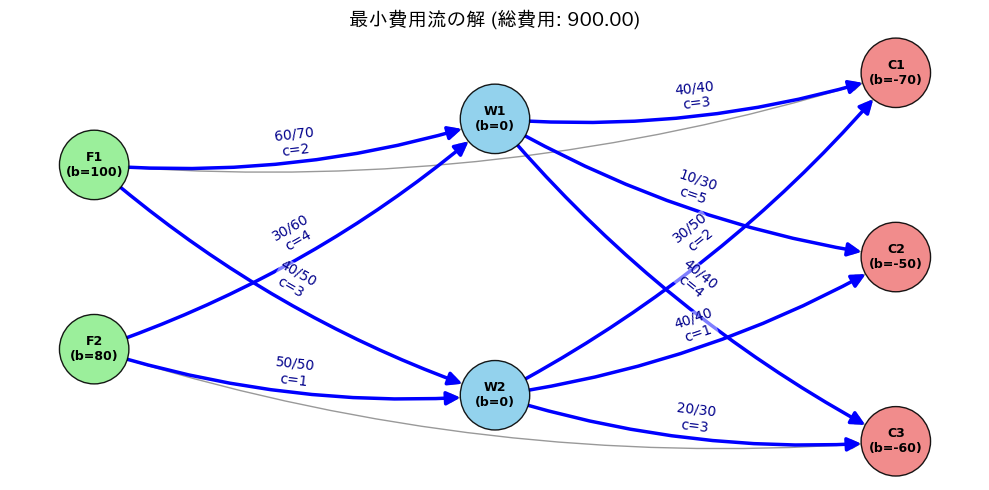

In [ ]:
#@title 結果の図示

if status == OptimizationStatus.OPTIMAL:
    flow_results_list_mcf = []
    for (i,j) in defined_arcs_mcf_mip:
        flow_val = x_flow[i,j].x
        if flow_val > 1e-6: # ごく小さいフローは無視して表示
            flow_results_list_mcf.append({
                "始点": i, "終点": j, "フロー量": flow_val,
                "費用": costs_mcf_mip[i,j], "容量": capacities_mcf_mip[i,j]
            })

    if flow_results_list_mcf:
        flow_df_mcf = pd.DataFrame(flow_results_list_mcf)

        # --- 最適フローの図示 ---
        G_mcf_sol = nx.DiGraph()
        # ノードと属性の再定義 (図示のため)
        nodes_data_mcf_sol = {
            'F1': {'balance': 100, 'type': 'supply', 'pos': (0, 2)}, 'F2': {'balance': 80,  'type': 'supply', 'pos': (0, 0)},
            'W1': {'balance': 0,   'type': 'transshipment', 'pos': (2, 2.5)}, 'W2': {'balance': 0,   'type': 'transshipment', 'pos': (2, -0.5)},
            'C1': {'balance': -70, 'type': 'demand', 'pos': (4, 3)}, 'C2': {'balance': -50, 'type': 'demand', 'pos': (4, 1)},
            'C3': {'balance': -60, 'type': 'demand', 'pos': (4, -1)}
        }
        G_mcf_sol.add_nodes_from(nodes_data_mcf_sol.keys())
        pos_mcf_sol = {name: data['pos'] for name, data in nodes_data_mcf_sol.items()}
        color_map_mcf_sol = ['lightgreen' if nodes_data_mcf_sol[n]['type']=='supply' else 'lightcoral' if nodes_data_mcf_sol[n]['type']=='demand' else 'skyblue' for n in G_mcf_sol.nodes()]
        node_labels_mcf_sol = {name: f"{name}\n(b={data['balance']})" for name, data in nodes_data_mcf_sol.items()}
        node_draw_size_mcf_sol = 2500

        # 元のアーク構造を背景として描画
        for u_orig, v_orig, cost_orig, cap_orig in arcs_data_mcf_mip:
             G_mcf_sol.add_edge(u_orig, v_orig, cost=cost_orig, capacity=cap_orig, flow=0) # 初期フロー0

        active_edges_with_flow_mcf = []
        for res in flow_results_list_mcf:
            u, v = res["始点"], res["終点"]
            if G_mcf_sol.has_edge(u,v): # 既存エッジの属性を更新
                G_mcf_sol.edges[u,v]['flow'] = res["フロー量"]
            else: # 通常は発生しないはず (defined_arcs_mcf_mip に基づくため)
                G_mcf_sol.add_edge(u,v, flow=res["フロー量"], capacity=res["容量"], cost=res["費用"])
            if res["フロー量"] > 1e-6 : active_edges_with_flow_mcf.append((u,v))


        plt.figure(figsize=(10, 5))
        nx.draw_networkx_nodes(G_mcf_sol, pos_mcf_sol, node_size=node_draw_size_mcf_sol, node_color=color_map_mcf_sol, alpha=0.9, edgecolors="black")
        nx.draw_networkx_labels(G_mcf_sol, pos_mcf_sol, labels=node_labels_mcf_sol, font_size=9, font_weight='bold')

        # 全てのアークを薄く描画
        all_problem_arcs = [(u,v) for u,v,c,cp in arcs_data_mcf_mip]
        nx.draw_networkx_edges(G_mcf_sol, pos_mcf_sol, edgelist=all_problem_arcs, width=1.0, alpha=0.8, edge_color='gray',
                               arrowstyle='-|> ', arrowsize=15, connectionstyle='arc3,rad=0.1',
                               node_size=node_draw_size_mcf_sol, min_source_margin=18, min_target_margin=18)

        # フローのあるアークを強調
        nx.draw_networkx_edges(G_mcf_sol, pos_mcf_sol, edgelist=active_edges_with_flow_mcf, width=2.5, arrowstyle='-|> ',
                               arrowsize=20, edge_color='blue', connectionstyle='arc3,rad=0.1',
                               node_size=node_draw_size_mcf_sol, min_source_margin=18, min_target_margin=18)

        edge_flow_labels_mcf = {}
        for u,v,d in G_mcf_sol.edges(data=True):
            if d.get('flow', 0) > 1e-6:
                edge_flow_labels_mcf[(u,v)] = f"{d['flow']:.0f}/{d['capacity']}\nc={d['cost']}"
            # else: # フローがないアークのラベルも表示する場合
            #     edge_flow_labels_mcf[(u,v)] = f"u={d['capacity']}\nc={d['cost']}"


        nx.draw_networkx_edge_labels(G_mcf_sol, pos_mcf_sol, edge_labels=edge_flow_labels_mcf, font_size=10, font_color='darkblue',
                                     bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=0.1))

        plt.title(f"最小費用流の解 (総費用: {model_mcf.objective_value:.2f})", fontsize=14)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

elif status == mip.OptimizationStatus.INFEASIBLE:
    print("実行不可能な問題です。制約を満たす解が存在しません。")
else:
    print(f"最適化が停止しました。ステータス: {status}")

### 結果の解釈

上記のコードを実行すると、定義されたネットワーク上で総輸送費用を最小にする各アーク上のフロー量が計算されます。
* **総費用:** 最小化された目的関数の値です。

* **各アークのフロー量:** どのルート（アーク）をどれだけの量で利用するのが最適かを示します。フロー量が0のアークは、その最適解では利用されないことを意味します。フロー量が容量上限に達しているアークは、そのルートがボトルネックになっている可能性を示唆します。
すなわち、上限を増やすことで費用削減の可能性があることを示唆している。

この結果を分析することで、輸送計画のボトルネックの特定や、コスト削減のための改善策（例：特定アークの容量拡大、新規ルートの開設、費用の見直しなど）を検討するのに役立ちます。

---
## モデルの発展

基本的な最小費用流問題は強力ですが、実世界の状況はさらに複雑な場合があります。モデルを改善・拡張する視点としては以下のようなものがあります。

* **複数種類製品のフロー（多品種フロー問題）:** 複数の異なる製品が同じネットワークリソース（アーク容量など）を共有する場合。各製品ごとにフロー変数と制約を定義し、共有リソースに関する制約を追加します。これはより複雑な問題となります。
* **アーク使用の固定費用:** 特定のアークを使用する場合に、流量に関わらず一定の固定費用が発生する場合。これは混合整数計画問題となり、アークを使用するか否かを示すバイナリ変数が必要になります。
* **時間軸を考慮したネットワーク（動的フロー問題）:** 在庫を考慮し、複数の期間にわたるフローを計画する場合。各時点のノードとアークを持つ時間展開ネットワークを構築します。
* **不均衡問題とペナルティ:** 総供給量と総需要量が一致しない場合。ダミーの供給ノードや需要ノードを追加し、満たされなかった需要や余剰供給に対するペナルティ費用を目的関数に導入してモデル化します（演習問題で扱います）。
* **損失・利得のあるアーク:** アークを通過する際に一定割合のフローが失われたり（例：電力送電ロス）、逆に増えたりする場合（例：金融取引における利子）
* **非線形コスト:** アーク上のフロー量に応じて単位費用が変化する場合（例：数量割引）。これは非線形計画問題となるが、混合整数計画問題で線形近似を行うことができる。


---
#演習問題

##演習問題1

基本例のアーク (F2, W2) の単位費用を 1 から 5 に増加させ、同時にアーク (W1, C1) の容量を 40 から 60 に増加させたとします。
総費用の最小値を求めよ。


##演習問題2

**問題:**
基本例のネットワークに、新たに倉庫W1から倉庫W2への輸送ルート (W1, W2) を追加することを考えます。この新しいルートの単位費用は 0、
容量は 30 であるとします。
総費用の最小値を求めよ。


##演習問題3

**問題:**
基本例において、顧客C1の需要量を -70 から -100 に増加させ、かつアーク (F1,W1) の容量を 70 から 30 に減少させたとします。
他の条件は例題と同じとする。
最適化を行い総費用の最小値最を求めよ。
最適値が無い場合は0と解答すること。

##演習問題4

**問題:**
あるネットワークのノードAからノードDへの最短経路を見つける問題を、最小費用流問題として定式化しなさい。ネットワークは以下のノードとアーク（およびアークの「費用」としての「距離」）を持つとします。
* ノード: A, B, C, D
* アークと費用 (距離):
    * (A, B, cost=5), (A, C, cost=2)
    * (B, C, cost=1), (B, D, cost=6)
    * (C, B, cost=2), (C, D, cost=8)
アークの容量は十分に大きい（例：1ユニット以上）と仮定します。

**考え方:**
1.  この問題を最小費用流問題としてモデル化します。始点Aの供給量を1 ($b_A=1$)、終点Dの需要量を1 ($b_D=-1$)とし、他の中継ノードB, Cのバランスは0 ($b_B=0, b_C=0$)とします。
2.  各アークの費用は与えられた距離、容量は全て1（またはそれ以上）とします。
3.  この最小費用流問題を解き、フローが1流れるアークが最短経路を構成すること、そして目的関数値がその経路長になることを確認しなさい。


##演習問題5

**問題:**
基本例のネットワークにおいて、顧客C3の需要量が 60 から 90 ユニットに増加したとします。このとき、総供給量(180)は新しい総需要量(70+50+90=210)に満たなくなります（30ユニット不足）。この状況で、満たされない需要1ユニットあたり15のペナルティ費用が発生すると仮定します。この問題を、ダミー供給ノードを用いて均衡させ、実際の輸送費用とペナルティ費用の合計を最小化せよ。費用の最小値を解答する。

**考え方**
1.  ダミー供給ノード（例：`DS`）をネットワークに追加します。
2.  このダミーノードの供給量は、需要超過分（この場合は $210-180=30$ ユニット）とします。
3.  ダミーノードから各実際の需要ノード（C1, C2, C3）へアークを張り、これらのアークの単位費用をペナルティ費用（15）とします。これらのダミーアークの容量は十分に大きく設定します（例：各需要ノードの需要量以上、または総不足分以上）。

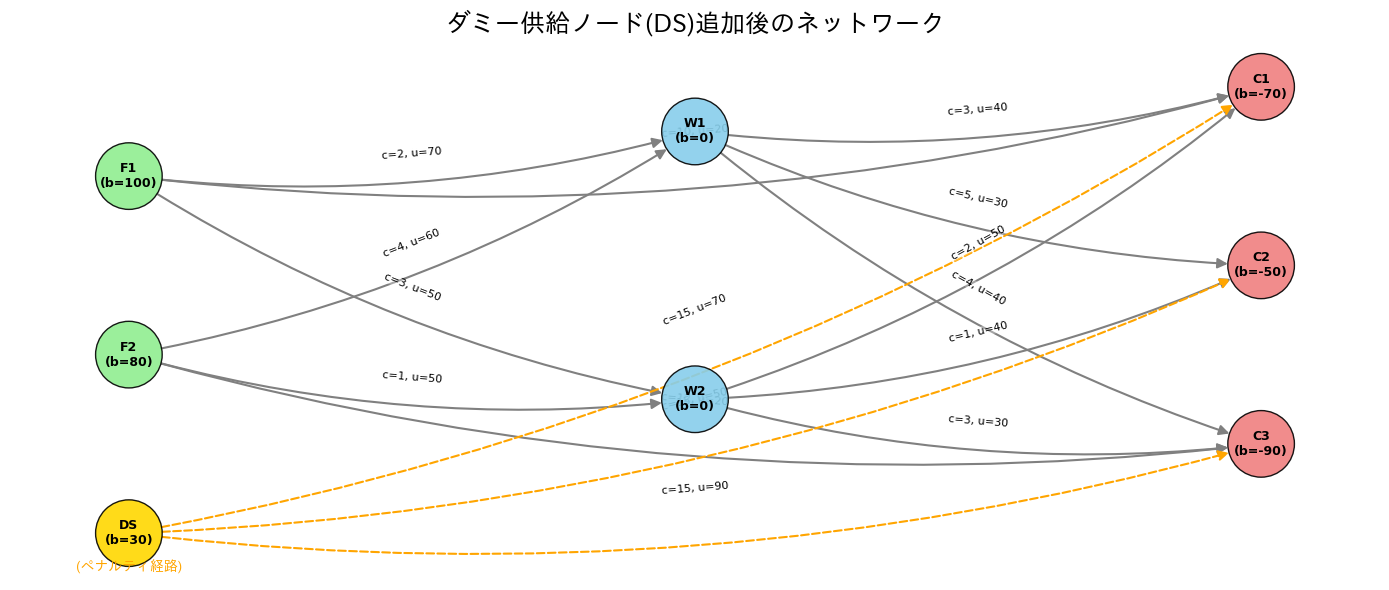

In [ ]:
#@title 図
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib #日本語フォント対応
import numpy as np
import pandas as pd # DataFrame表示用 (MIPコードで使用)

# --- ネットワークデータ (応用演習1用) ---
nodes_data_adv1_fig = {
    'F1': {'balance': 100, 'type': 'supply', 'pos': (0, 2.5)},
    'F2': {'balance': 80,  'type': 'supply', 'pos': (0, 0.5)},
    'W1': {'balance': 0,   'type': 'transshipment', 'pos': (2, 3)},
    'W2': {'balance': 0,   'type': 'transshipment', 'pos': (2, 0)},
    'C1': {'balance': -70, 'type': 'demand', 'pos': (4, 3.5)},
    'C2': {'balance': -50, 'type': 'demand', 'pos': (4, 1.5)},
    'C3': {'balance': -90, 'type': 'demand', 'pos': (4, -0.5)}, # 需要変更
    'DS': {'balance': 30,  'type': 'dummy_supply', 'pos': (0, -1.5)} # ダミー供給ノード
}
arcs_data_adv1_fig = [
    # 元のアーク
    ('F1', 'W1', 2, 70), ('F1', 'W2', 3, 50),
    ('F2', 'W1', 4, 60), ('F2', 'W2', 1, 50),
    ('W1', 'C1', 3, 40), ('W1', 'C2', 5, 30), ('W1', 'C3', 4, 40),
    ('W2', 'C1', 2, 50), ('W2', 'C2', 1, 40), ('W2', 'C3', 3, 30),
    ('F1', 'C1', 10, 20),('F2', 'C3', 12, 20),
    # ダミーアーク (費用=ペナルティ15)
    ('DS', 'C1', 15, 70), # 容量は各需要量（またはそれ以上）
    ('DS', 'C2', 15, 50),
    ('DS', 'C3', 15, 90)
]

# グラフオブジェクトの作成
G_adv1_fig = nx.DiGraph()
node_names_adv1_fig = list(nodes_data_adv1_fig.keys())
G_adv1_fig.add_nodes_from(node_names_adv1_fig)

for u, v, cost, capacity in arcs_data_adv1_fig:
    G_adv1_fig.add_edge(u, v, cost=cost, capacity=capacity)

# ノードの描画位置
pos_adv1_fig = {name: data['pos'] for name, data in nodes_data_adv1_fig.items()}

# ノードの色分け
color_map_adv1_fig = []
for node_name in G_adv1_fig.nodes():
    node_type = nodes_data_adv1_fig[node_name]['type']
    if node_type == 'supply': color_map_adv1_fig.append('lightgreen')
    elif node_type == 'demand': color_map_adv1_fig.append('lightcoral')
    elif node_type == 'dummy_supply': color_map_adv1_fig.append('gold')
    else: color_map_adv1_fig.append('skyblue') # transshipment

# 描画
plt.figure(figsize=(14, 6))
node_draw_size_adv1_fig = 2300

nx.draw_networkx_nodes(G_adv1_fig, pos_adv1_fig, node_size=node_draw_size_adv1_fig,
                       node_color=color_map_adv1_fig, alpha=0.9, edgecolors="black")
node_labels_adv1_fig = {name: f"{name}\n(b={data['balance']})" for name, data in nodes_data_adv1_fig.items()}
nx.draw_networkx_labels(G_adv1_fig, pos_adv1_fig, labels=node_labels_adv1_fig, font_size=9, font_weight='bold')

# ダミーアークと通常アークでスタイルを分ける
normal_arcs = [e for e in G_adv1_fig.edges() if e[0] != 'DS']
dummy_arcs = [e for e in G_adv1_fig.edges() if e[0] == 'DS']

nx.draw_networkx_edges(G_adv1_fig, pos_adv1_fig, edgelist=normal_arcs, width=1.5, arrowstyle='-|> ', arrowsize=15,
                       edge_color='gray', connectionstyle='arc3,rad=0.1', node_size=node_draw_size_adv1_fig,
                       min_source_margin=18, min_target_margin=18)
nx.draw_networkx_edges(G_adv1_fig, pos_adv1_fig, edgelist=dummy_arcs, width=1.5, arrowstyle='-|> ', arrowsize=15,
                       edge_color='orange', style='dashed', connectionstyle='arc3,rad=0.1',
                       node_size=node_draw_size_adv1_fig, min_source_margin=18, min_target_margin=18)


edge_labels_adv1_fig = {(u,v): f"c={d['cost']}, u={d['capacity']}" for u,v,d in G_adv1_fig.edges(data=True)}
nx.draw_networkx_edge_labels(G_adv1_fig, pos_adv1_fig, edge_labels=edge_labels_adv1_fig, font_size=8, font_color='black',
                             bbox=dict(facecolor='white', alpha=0.3, edgecolor='none', pad=0.1))

plt.title("ダミー供給ノード(DS)追加後のネットワーク", fontsize=18)
plt.text(pos_adv1_fig['DS'][0], pos_adv1_fig['DS'][1]-0.3, '(ペナルティ経路)', ha='center', va='top', fontsize=10, color='orange')
plt.axis('off')
plt.tight_layout()
plt.show()